<a href="https://colab.research.google.com/github/gheesung/object_detection_assignment/blob/master/Object_Detection_Detecting_Dark_Vader_in_Star_Wars_movie_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tensorflow Object Detection API 

This assignment uses the API to detect Dark Vader in Star Wars movie clip. The clip is analysed to mark out Dark Vader when it appears in the scene. There are some false detections detected.

## Final result

[Original Video](https://www.youtube.com/watch?v=P_PZGECoJT0)

[Processed Video](https://youtu.be/Yq_IbKCQF7Q)

## Setup the pre-requisite for tensorflow object detection API

In [0]:

!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

    100% |████████████████████████████████| 993kB 18.5MB/s 
/content/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.082s

OK (skipped=1)


### All my data is stored in Google Drive.This is a good way to keep the training data and model persistence.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# my Dark Varder Training Data in Google Drive
!ls /gdrive/My\ Drive/Colab\ Notebooks/objectdetection/images


darkvader_001.jpg  darkvader_010.jpg  darkvader_019.jpg  darkvader_028.jpg
darkvader_002.jpg  darkvader_011.jpg  darkvader_020.jpg  darkvader_029.jpg
darkvader_003.jpg  darkvader_012.jpg  darkvader_021.jpg  darkvader_030.jpg
darkvader_004.jpg  darkvader_013.jpg  darkvader_022.jpg  darkvader_031.jpg
darkvader_005.jpg  darkvader_014.jpg  darkvader_023.jpg  darkvader_032.jpg
darkvader_006.jpg  darkvader_015.jpg  darkvader_024.jpg  darkvader_033.jpg
darkvader_007.jpg  darkvader_016.jpg  darkvader_025.jpg  darkvader_034.jpg
darkvader_008.jpg  darkvader_017.jpg  darkvader_026.jpg  darkvader_035.jpg
darkvader_009.jpg  darkvader_018.jpg  darkvader_027.jpg


## Setup the dataset for training 

In [0]:
!echo "item { id: 1 name: 'darkvader'}" > label_map.pbtxt

In [0]:
image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

##Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [0]:
%cd annotations
!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

In [0]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/objectdetection

/gdrive/My Drive/Colab Notebooks/objectdetection


## Create TFRecord

In [0]:

!python /content/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

/content/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record

## Download pretrained model
Downloads faster_rcnn_inception_v2_coco model 

In [0]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/objectdetection

import os
import shutil
import glob
from urllib.request import urlopen
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/gdrive/My Drive/Colab Notebooks/objectdetection


## Edit model config file

In [0]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/objectdetection

import re

filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/gdrive/My Drive/Colab Notebooks/objectdetection/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/gdrive/My Drive/Colab Notebooks/objectdetection/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/gdrive/My Drive/Colab Notebooks/objectdetection/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/gdrive/My Drive/Colab Notebooks/objectdetection/label_map.pbtxt', s)
  f.write(s)

/gdrive/My Drive/Colab Notebooks/objectdetection


## Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.

In [0]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/objectdetection

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/gdrive/My\ Drive/Colab\ Notebooks/objectdetection/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500

/gdrive/My Drive/Colab Notebooks/objectdetection

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:

Future major versions of T

# Export trained model
Export trained model with highest step number in filename.

In [0]:
%cd /gdrive/My Drive/Colab Notebooks/objectdetection

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/gdrive/My Drive/Colab Notebooks/objectdetection
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
360 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             

# Run Inference

In [0]:
%cd /gdrive/My Drive/Colab Notebooks/objectdetection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

/gdrive/My Drive/Colab Notebooks/objectdetection


In [0]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("/content/models/research/")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline




from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [0]:
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/gdrive/My Drive/Colab Notebooks/objectdetection/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/gdrive/My Drive/Colab Notebooks/objectdetection', 'label_map.pbtxt')

NUM_CLASSES = 37

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/gdrive/My Drive/Colab Notebooks/objectdetection/samples'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

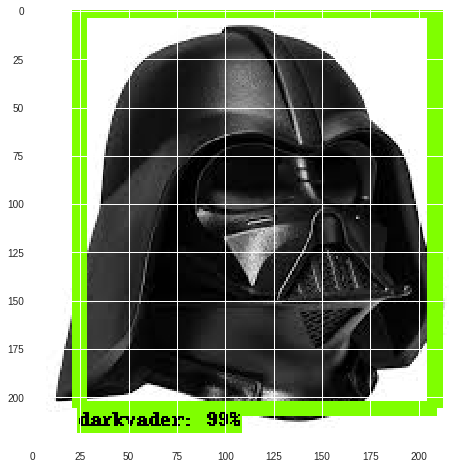

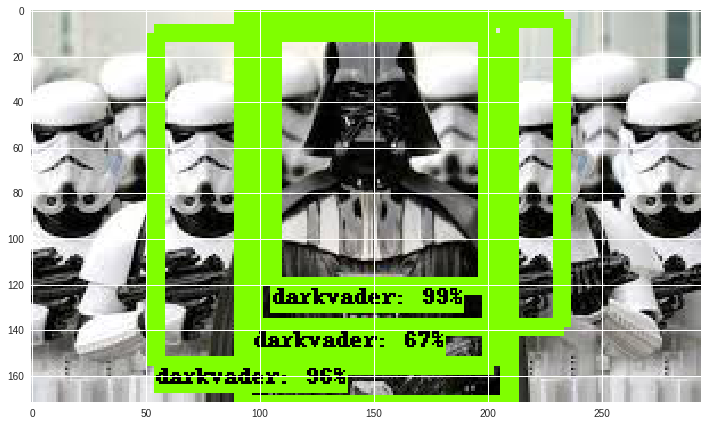

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [0]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

(225, 225) (225, 225, 3)


In [0]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [0]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)
   

(225, 225) (225, 225, 3)
(294, 172) (172, 294, 3)


## Detecting Dark Vader in Star Wars clip

In [0]:
%cd /gdrive/My Drive/Colab Notebooks/objectdetection

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

/gdrive/My Drive/Colab Notebooks/objectdetection
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1384448/45929032 bytes (3.0%)4726784/45929032 bytes (10.3%)8249344/45929032 bytes (18.0%)11722752/45929032 bytes (25.5%)15220736/45929032 bytes (33.1%)18759680/45929032 bytes (40.8%)22224896/45929032 bytes (48.4%)25559040/45929032 bytes (55.6%)28712960/45929032 bytes (62.5%)32202752/45929032 bytes (70.1%)35758080/45929032 bytes (77.9%)38854656/459

In [0]:
white_output = '/gdrive/My Drive/Colab Notebooks/objectdetection/video1_out.mp4'
clip1 = VideoFileClip("/gdrive/My Drive/Colab Notebooks/objectdetection/samples/Darth_Vader_Attacks.mp4").subclip(15,90)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /gdrive/My Drive/Colab Notebooks/objectdetection/video1_out.mp4
[MoviePy] Writing video /gdrive/My Drive/Colab Notebooks/objectdetection/video1_out.mp4


100%|██████████| 1799/1799 [1:24:14<00:00,  2.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /gdrive/My Drive/Colab Notebooks/objectdetection/video1_out.mp4 

CPU times: user 1h 20min 35s, sys: 2min 3s, total: 1h 22min 38s
Wall time: 1h 24min 14s


## Final result

[Original Video](https://www.youtube.com/watch?v=P_PZGECoJT0)

[Processed Video](https://youtu.be/Yq_IbKCQF7Q)